# Assignment 1 - Hybrid Images

Hybrid Images are the result of blending the high frequency features of one image with the low frequency features of another. The resulting image has the interesting property of appearing the be two different images, depending on viewing distance. This is a quirk of human perception; when viewing up close our brains put more emphasis on details, contours, and textures, when viewing far away we put the emphasis on color and shape. In this document I demonstrate two methods for producing such images: transformations in the Spatial Domain (pixel values) and the Frequency Domain (results of a Fourier transform).

In [49]:
import numpy as np
import numpy.fft as fft
import scipy.ndimage as im
import skimage as sk
import skimage.io as io
import skimage.filters as filt

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

First we need some subjects to experiment on:

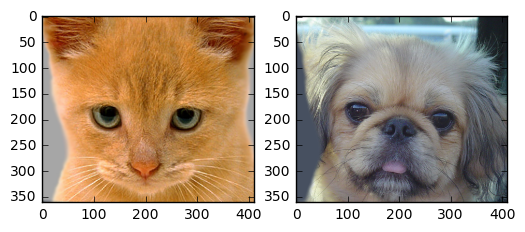

In [15]:
img_a = sk.img_as_float(im.imread("../data/3a.bmp"))
img_b = sk.img_as_float(im.imread("../data/3b.bmp"))

_, ax = plt.subplots(1,2)
ax[0].imshow(img_a)
ax[1].imshow(img_b)

# Transformations in the Image Domain

Creating hybrid images in the image domain is fairly straight forward. Low level features are derived by simply applying a Gaussian blur. High level features are derived by doing the same then subtracting the original image. This leaves behind only the high frequency details of the image, as shown below:

/Users/connor/anaconda/envs/cs636/lib/python3.5/site-packages/skimage/filters/_gaussian.py:94: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


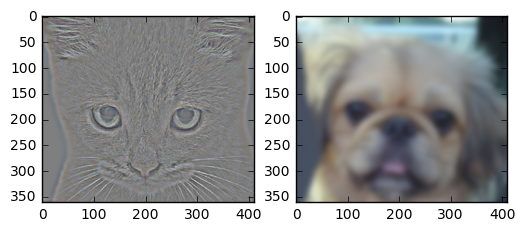

In [20]:
gauss = filt.gaussian

high = img_a - gauss(img_a, 5.)
low = gauss(img_b, 5.)

_, ax = plt.subplots(1,2)
ax[0].imshow(0.5+high)
ax[1].imshow(low)

This pair of isolated images are then added together to form a hybrid image, as shown below:

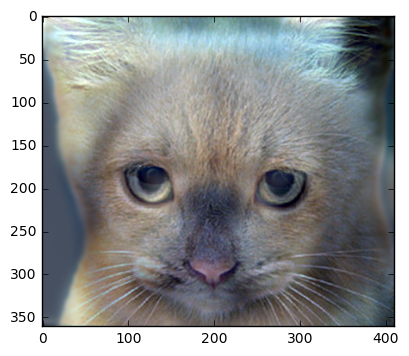

In [23]:
def spat_hybrid_image(A, B, sigma_a, sigma_b):
    gauss = filt.gaussian

    high = A - gauss(A, sigma_a)
    low = gauss(B, sigma_b)

    H = (low + high)
    H = np.clip(H, 0., 1.)
    
    return H
    
@interact(
    A=fixed(img_a), B=fixed(img_b), 
    sigma=widgets.IntSlider(min=0.1, max=50., value=5.)
)
def demo_combine(A, B, sigma):
    H = spat_hybrid_image(A, B, sigma, sigma)
    plt.imshow(H)

# Transformations in the Frequency Domain

## Converting Images to Frequency Domain

Before continuing, we must first convert our images from the spatial domain to the frequency domain. The standard approach is to apply the Fast Fourier Transform to the image. Below I display the first channel of the resulting frequency image for both of our demo images.

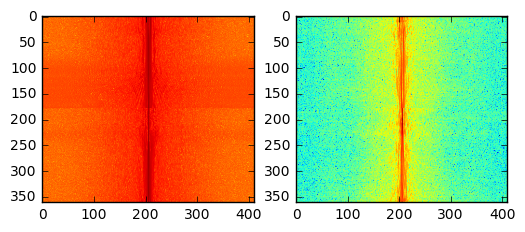

In [3]:
F = fft.fftshift(fft.fft2(img_a))
G = fft.fftshift(fft.fft2(img_b))

_, ax = plt.subplots(1,2)
ax[0].imshow(np.log(np.abs(F[:,:,0])))
ax[1].imshow(np.log(np.abs(G[:,:,0])))

## Filtering Images

Since the "pixels" in the frequency domain correspond to the frequency of changes in the parent image, any changes made here will affect the image globally. Important: pixels in the center of a frequency image correspond with the low frequency changes, and those far from the center correspond with high frequency changes. Thus, if we want to combine only the high level features from one image with the low level features of another, we must extract, or mask out, a circle of some radius from the center of the frequency image. A demonstration of the filtering is shown below on images in the spatial domain.

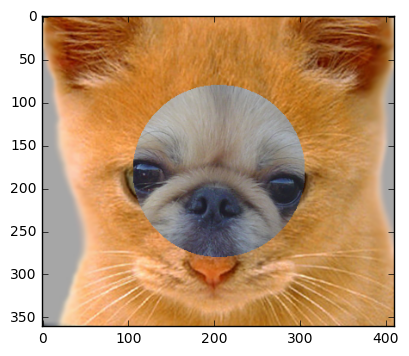

In [4]:
def mask_r(img, r, inv=False):
    a, b, _ = img.shape
    aa, bb = a/2, b/2

    y,x = np.ogrid[-aa:a-aa, -bb:b-bb]
    circle = x*x + y*y <= r*r

    mask = np.ones(img.shape)
    mask[circle] = 0.

    if inv:
        mask = -1 * mask + 1

    return img * mask

@interact(r=widgets.IntSlider(min=1, max=300, value=120))
def mask_r_demo(r):
    foo = mask_r(img_a, r, False)
    bar = mask_r(img_b, r, True)
    plt.imshow(foo+bar)

Below I demonstrate this filtering and combination process in the actual frequency domain.

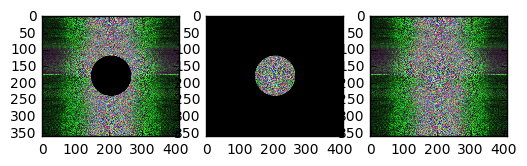

In [5]:
@interact(r=widgets.IntSlider(min=1, max=200, value=60))
def mask_r_demo(r):
    foo = mask_r(F, r, False).squeeze()
    bar = mask_r(G, r, True).squeeze()
    baz = foo+bar
        
    _, ax = plt.subplots(1,3)
    ax[0].imshow(np.abs(foo))
    ax[1].imshow(np.abs(bar))
    ax[2].imshow(np.abs(baz))

## Putting It All Together

Finally, after transforming to frequency domain, selecting high and low frequency features, and combining into a few frequency image, we are ready to convert back to the spatial domain. Once we have our combined frequency image, we simply perform the Inverse Fast Fourier Transform, to return it to the spatial domain. Below I demonstrate the complete process.

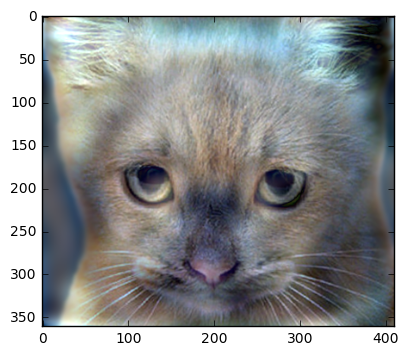

In [22]:
def freq_hybrid_image(img_a, img_b, r_a, r_b):
    fft_a = fft.fftshift(fft.fftn(img_a))
    fft_b = fft.fftshift(fft.fftn(img_b))

    A = mask_r(fft_a, r_a)
    B = mask_r(fft_b, r_b, inv=True)

    H = A + B

    img_a_ = np.abs(fft.ifftn(fft.ifftshift(A)))
    img_b_ = np.abs(fft.ifftn(fft.ifftshift(B)))
    img_h = np.abs(fft.ifftn(fft.ifftshift(H)))
    img_h = np.clip(img_h, 0, 1)
    
    return img_h

@interact(
    img_a=fixed(img_a), img_b=fixed(img_b), ax=fixed(plt),
    r=widgets.IntSlider(min=0, max=100, value=20)
)
def demo_hybrid_image(img_a, img_b, r):
    H = freq_hybrid_image(img_a, img_b, r, r)
    plt.imshow(H)

# Conclusion and Results

/Users/connor/anaconda/envs/cs636/lib/python3.5/site-packages/skimage/filters/_gaussian.py:94: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))
/Users/connor/anaconda/envs/cs636/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


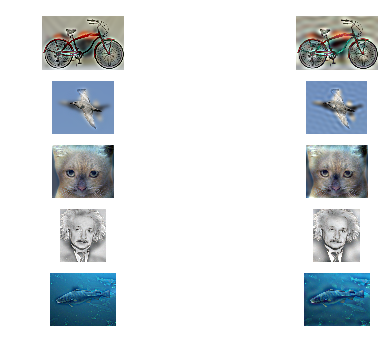

In [50]:
temp = "../data/%d%s.bmp"
dest = "../output/%d_%s.bmp"

fig, ax = plt.subplots(5, 2)

config = {
    1: [7, 8],
    2: [10, 10],
    3: [7, 11],
    4: [4, 7],
    5: [6, 6]
}

for pair_id, (freq, spat) in config.items():
    img_a = sk.img_as_float(im.imread(temp%(pair_id,"a")))
    img_b = sk.img_as_float(im.imread(temp%(pair_id,"b")))
    
    SH = spat_hybrid_image(img_a, img_b, spat, spat)
    FH = freq_hybrid_image(img_a, img_b, freq, freq)
    
    io.imsave(dest%(pair_id, "s"), SH)
    io.imsave(dest%(pair_id, "f"), FH)
    
    # plotting
    ax[pair_id-1, 0].imshow(SH)
    ax[pair_id-1, 0].axis("off")
    ax[pair_id-1, 1].imshow(FH)
    ax[pair_id-1, 1].axis("off")
    

And finally, a hybrid image using images not provided to us as part of the assignment. I felt that given current events, a hybrid image of Steve Bannon and Donald Trump would be relevant. These were the closest to aligned that I could find.

/Users/connor/anaconda/envs/cs636/lib/python3.5/site-packages/skimage/filters/_gaussian.py:94: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))
/Users/connor/anaconda/envs/cs636/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


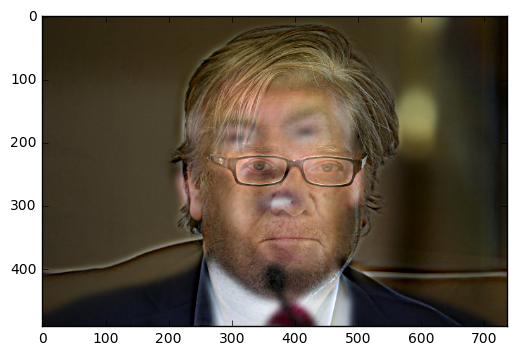

In [51]:
@interact(
    spat=widgets.IntSlider(min=0.1, max=50., value=5.)
)
def foo(spat):
    img_a = sk.img_as_float(im.imread("../data/ste.jpg"))
    img_b = sk.img_as_float(im.imread("../data/don.jpg"))

    SH = spat_hybrid_image(img_a, img_b, spat, spat)
    io.imsave("../output/donald_bannon.jpg", SH)

    # plotting
    plt.imshow(SH)